In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cftime
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [3]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), 'Documents', 'zecmip_stabilisation'))
import constants
sys.path.append(constants.MODULE_DIR)
import signal_to_noise_calculations as sn_calc
import my_stats

In [4]:
np.set_printoptions(precision=6, suppress=True, edgeitems=1)
xr.set_options(display_expand_data=False)

In [78]:
def find_stability_index(arr: np.ndarray, window: int, fraction: float = 0.5) -> int:
    """
    Determines the index at which stability is achieved in the input array.

    The algorithm works by sliding a window of a specified length over the array,
    checking each subset to determine if the fraction of unstable values (i.e., 
    values that are not finite) is below a certain threshold. If the fraction of 
    unstable values in a subset is below the threshold, the index where stability 
    is achieved is determined based on the last unstable value within the subset.

    If stability is achieved in the current subset, the function further checks if 
    the next element after the stable period is also stable by counting the number 
    of consecutive stable elements. The final index of stability is adjusted 
    accordingly.

    If stability is never achieved within the array, the function returns an 
    index calculated as the last checked index plus half the window length.

    Parameters:
    arr (np.ndarray): The input array containing numerical values.
    window (int): The length of the window used for stability checking.
    fraction (float): The threshold fraction of instability (default is 0.5).

    Returns:
    int: The index at which stability is first achieved.
    """
    finite_arr = np.isfinite(arr)

    lenght_of_selection = np.min([20, window])#window#int(window/2)

    for sel_start in range(len(finite_arr)-lenght_of_selection):
        # Make sub-selection
        finite_arr_selection = finite_arr[sel_start:sel_start+lenght_of_selection]
        # Number that are unstable (unstable =1, stable = 0)
        number_unstable = np.sum(finite_arr_selection)
        # Fraction that is unstalbe
        fraction_unstable = number_unstable/lenght_of_selection
        
        # If < 0.2 is unstalbe, then call stability immediately. Do not add consecs     
        if fraction_unstable < 0.33:
            return sel_start

        # If the fraction is less than fraciton - stability is achieved
        if fraction_unstable < fraction:
            # Figure out where the last unstable value occurs in selection
            last_arg = np.argwhere(finite_arr_selection==1)
            last_arg = last_arg[-1][-1] if len(last_arg) > 0 else 0
            last_arg = last_arg+1 # Always one behind, so add 1
            stable_year = sel_start + last_arg
            
            # The next element is one after the stable year - so why should it be stable there?
            if finite_arr[stable_year+1] == 1: 
                cosec_after_stabilisation = sn_calc.count_consecutive_ones(finite_arr[stable_year+1:])
                stable_year = stable_year + cosec_after_stabilisation+1

            stable_year = stable_year
            return stable_year

    # Stability never achieved return arg + the offset
    return sel_start + int(window/2)

# Setup - Demonstation

In [104]:
simulation_length = 150
trend_length = 50
trend_step = 0.01 # 0.1
pi_length = 500

print(trend_length * trend_step)

linear_trend = np.arange(0, trend_length * trend_step, trend_step)
linear_trend = np.concatenate([linear_trend, [linear_trend[-1]] * (simulation_length-trend_length)])
random_noise = np.random.normal(0, 0.2, len(linear_trend))
time_series = linear_trend + random_noise

pi_control = np.random.normal(0, 0.2, pi_length)

0.5


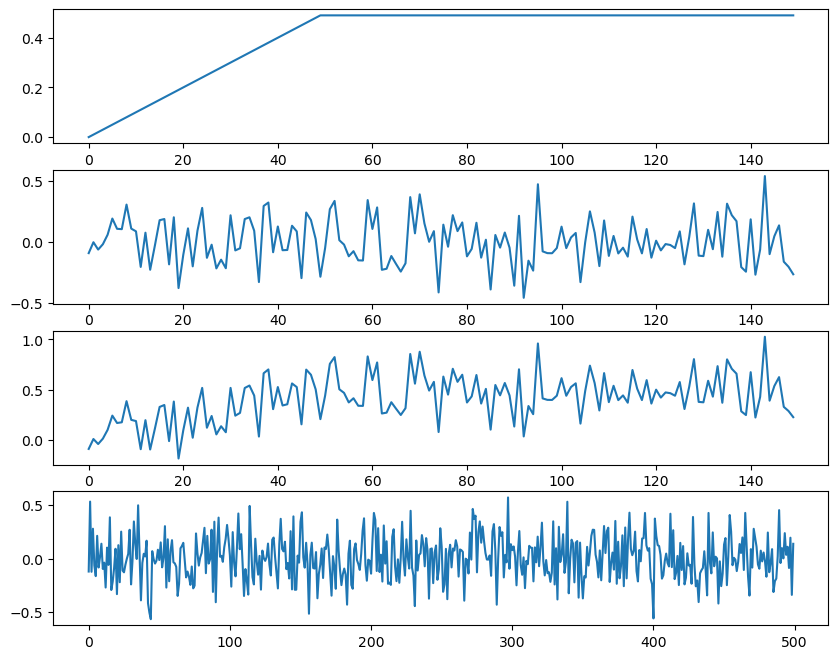

In [105]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
ax1.plot(linear_trend)
ax2.plot(random_noise)
ax4.plot(pi_control)
ax3.plot(time_series)

In [106]:
# Create a cftime range starting at year 0 for 100 years with yearly frequency
time = xr.cftime_range(start=cftime.datetime(1,1,1,0,0,0), periods=len(time_series), freq='YS')
pitime = xr.cftime_range(start=cftime.datetime(1,1,1,0,0,0), periods=len(pi_control), freq='YS')

# Create the DataArray
da = xr.DataArray(
    time_series,
    coords={
        "time": time
    },
    dims="time",
    name="tas"
)

pi_da = xr.DataArray(
    pi_control,
    coords={
        "time": pitime
    },
    dims="time",
    name="tas"
)

In [107]:
da

<xarray.DataArray 'tas' (time: 150)> Size: 1kB
-0.0931 0.005935 -0.04406 0.009815 0.09744 ... 0.5349 0.6239 0.327 0.2856 0.2241
Coordinates:
  * time     (time) object 1kB 0001-01-01 00:00:00 ... 0150-01-01 00:00:00

In [108]:
da_trend =  my_stats.trend_fit(da, method='polynomial', order=4)
da_detrend = da - da_trend

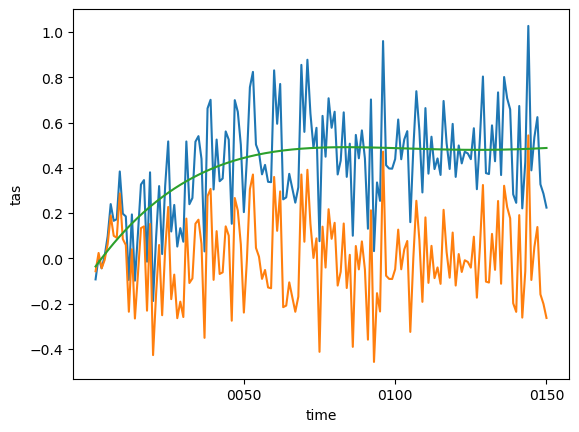

In [109]:
da.plot()
da_detrend.plot()
da_trend.plot()

In [110]:
windows = np.arange(**constants.ZECMIP_MULTI_WINDOW_PARAMS)
windows

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])

In [111]:
sn_da = sn_calc.signal_to_noise_ratio_multi_window(
    da, 
    windows,
    detrended_data=da_detrend,
    parallel=False,
    noise_type='static',
    logginglevel='ERROR'
)


In [112]:
sn_pi_da = sn_calc.signal_to_noise_ratio_multi_window(
    pi_da, 
    windows,
    parallel=False,
    noise_type='static',
    logginglevel='ERROR'
)

In [113]:
bounds_ds = sn_calc.upper_and_lower_bounds(sn_pi_da, 5, 95)

In [114]:
# The S/N ratio that is unstable - e.g. the A1 S/N where the pi-control is unstable
unstable_sn_da = sn_da.where(np.logical_or(
    sn_da>bounds_ds.upper_bound, # Greater than upper-bounds
    sn_da<bounds_ds.lower_bound)
                                     ) # Less than lower bound

In [115]:
# Get the year that stabilisation occurs
# Note: NOt sure why, but if this isn't done in two parts, this returns a tranpose error.
year_stable_kwargs = dict(
    input_core_dims=[['time'], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[np.float]
)

year_stable_all_window_da =xr.apply_ufunc(
    find_stability_index,
    unstable_sn_da,
    unstable_sn_da.window,
    **year_stable_kwargs
).compute()


In [116]:
unstable_sn_da['time'] = unstable_sn_da.time.dt.year.values

In [117]:
trend_length

50

In [118]:
year_stable_da = year_stable_all_window_da.max(dim='window')
year_stable_da

<xarray.DataArray ()> Size: 8B
32.0

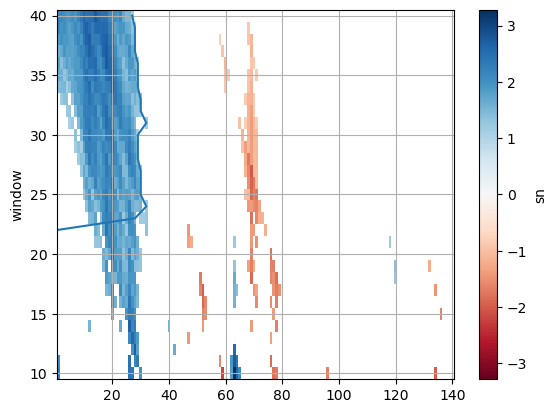

In [119]:
unstable_sn_da.plot(cmap='RdBu')
year_stable_all_window_da.plot(y='window')
plt.grid()

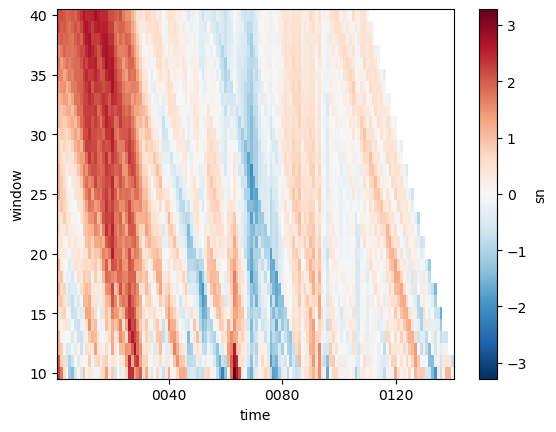

In [120]:
sn_da.plot()

# Distributions

In [121]:
import dask

In [122]:
# client.close()

In [123]:
from dask.distributed import Client
client = Client(memory_limit=None, threads_per_worker=1, n_workers=12)
client

- State start
- Found stale lock file and directory '/jobfs/122371046.gadi-pbs/dask-scratch-space/scheduler-qegt8fff', purging
-   Scheduler at:     tcp://127.0.0.1:46277
-   dashboard at:         /proxy/8787/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:42017'
-         Start Nanny at: 'tcp://127.0.0.1:32881'
-         Start Nanny at: 'tcp://127.0.0.1:41017'
-         Start Nanny at: 'tcp://127.0.0.1:38131'
-         Start Nanny at: 'tcp://127.0.0.1:35163'
-         Start Nanny at: 'tcp://127.0.0.1:33833'
-         Start Nanny at: 'tcp://127.0.0.1:44901'
-         Start Nanny at: 'tcp://127.0.0.1:43291'
-         Start Nanny at: 'tcp://127.0.0.1:42883'
-         Start Nanny at: 'tcp://127.0.0.1:42357'
-         Start Nanny at: 'tcp://127.0.0.1:34317'
-         Start Nanny at: 'tcp://127.0.0.1:45833'
- Register worker <WorkerState 'tcp://127.0.0.1:34219', name: 7, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 12
Total threads: 12,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46277,Workers: 12
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33773,Total threads: 1
Dashboard: /proxy/44599/status,Memory: 0 B
Nanny: tcp://127.0.0.1:42017,


- Register worker <WorkerState 'tcp://127.0.0.1:35519', name: 13, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:35519
- Starting established connection to tcp://127.0.0.1:59558
- Register worker <WorkerState 'tcp://127.0.0.1:46807', name: 12, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:46807
- Starting established connection to tcp://127.0.0.1:59580
- Register worker <WorkerState 'tcp://127.0.0.1:43681', name: 20, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:43681
- Starting established connection to tcp://127.0.0.1:59564
- Register worker <WorkerState 'tcp://127.0.0.1:38731', name: 14, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:38731
- Starting established connection to tcp://127.0.0.1:59596
- Register worker <WorkerState 'tcp://127.0.0.1:36105', name: 18, status: init, memory: 0, processing: 0>
- Starting

In [124]:
client.cluster.scale(30)

-         Start Nanny at: 'tcp://127.0.0.1:40001'
-         Start Nanny at: 'tcp://127.0.0.1:46637'
-         Start Nanny at: 'tcp://127.0.0.1:33957'
-         Start Nanny at: 'tcp://127.0.0.1:36443'
-         Start Nanny at: 'tcp://127.0.0.1:36973'
-         Start Nanny at: 'tcp://127.0.0.1:33381'
-         Start Nanny at: 'tcp://127.0.0.1:40771'
-         Start Nanny at: 'tcp://127.0.0.1:43873'
-         Start Nanny at: 'tcp://127.0.0.1:45025'
-         Start Nanny at: 'tcp://127.0.0.1:42105'
-         Start Nanny at: 'tcp://127.0.0.1:44039'
-         Start Nanny at: 'tcp://127.0.0.1:35903'
-         Start Nanny at: 'tcp://127.0.0.1:40685'
-         Start Nanny at: 'tcp://127.0.0.1:46811'
-         Start Nanny at: 'tcp://127.0.0.1:38973'
-         Start Nanny at: 'tcp://127.0.0.1:35035'
-         Start Nanny at: 'tcp://127.0.0.1:45049'
-         Start Nanny at: 'tcp://127.0.0.1:39223'
- Closing Nanny gracefully at 'tcp://127.0.0.1:35903'. Reason: worker-handle-scheduler-connection-br

In [125]:
def do_everything(trend_step, trend_length, variance=0.2):
    pi_length = 500
    simulation_length = 100
    linear_trend = np.arange(0, trend_length * trend_step, trend_step)
    linear_trend = np.concatenate([linear_trend, [linear_trend[-1]] * (simulation_length-trend_length)])
    random_noise = np.random.normal(0, variance, len(linear_trend))
    time_series = linear_trend + random_noise
    
    pi_control = np.random.normal(0, variance, pi_length)

    # Create a cftime range starting at year 0 for 100 years with yearly frequency
    time = xr.cftime_range(start=cftime.datetime(1,1,1,0,0,0), periods=len(time_series), freq='YS')
    pitime = xr.cftime_range(start=cftime.datetime(1,1,1,0,0,0), periods=len(pi_control), freq='YS')
    
    # Create the DataArray
    da = xr.DataArray(
        time_series,
        coords={
            "time": time
        },
        dims="time",
        name="tas"
    )
    
    pi_da = xr.DataArray(
        pi_control,
        coords={
            "time": pitime
        },
        dims="time",
        name="tas"
    )
    
    
    da_trend =  my_stats.trend_fit(da, method='polynomial', order=4)
    da_detrend = da - da_trend
    
    sn_da = sn_calc.signal_to_noise_ratio_multi_window(
        da, 
        windows,
        detrended_data=da_detrend,
        parallel=False,
        noise_type='static',
        logginglevel='ERROR'
    )
    sn_pi_da = sn_calc.signal_to_noise_ratio_multi_window(
        pi_da, 
        windows,
        parallel=False,
        noise_type='static',
        logginglevel='ERROR'
    )
    
    bounds_ds = sn_calc.upper_and_lower_bounds(sn_pi_da, 5, 95)
    
    # The S/N ratio that is unstable - e.g. the A1 S/N where the pi-control is unstable
    unstable_sn_da = sn_da.where(np.logical_or(
        sn_da>bounds_ds.upper_bound, # Greater than upper-bounds
        sn_da<bounds_ds.lower_bound)
                                         ) # Less than lower bound
    
    
    # Get the year that stabilisation occurs
    # Note: NOt sure why, but if this isn't done in two parts, this returns a tranpose error.
    year_stable_kwargs = dict(
        input_core_dims=[['time'], []],
        output_core_dims=[[]],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[np.float]
    )
    
    year_stable_all_window_da =xr.apply_ufunc(
        find_stability_index,
        unstable_sn_da,
        unstable_sn_da.window,
        **year_stable_kwargs
    ).compute()
    
    
    year_stable_da = year_stable_all_window_da.max(dim='window')
    return year_stable_da.values.item()

In [132]:
number_runs = 300

In [133]:
np.arange(0.001, 0.001*11, 0.001) * 50

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

In [134]:
variance = 0.2

In [135]:
%%time
trend_step_dict = {}
# np.arange(0.01, 0.11, 0.01)
for trend_step in np.arange(0.001, 0.001*11, 0.001):
    print(f'\n{trend_step=}\n--------------\n')
    trend_dict = {}
    for trend_length in range(10, 55, 5):
        print(f'{trend_length=}, total_change = {trend_step*trend_length}\n')
        year_list = []
        for i in range(number_runs):
            # print(f'{i}, ', end='')
            year = dask.delayed(do_everything)(trend_step, trend_length, variance=variance)
            year_list.append(year)
        year_list = dask.compute(year_list)[0]
        trend_dict[trend_length] = year_list
    trend_step_dict[trend_step] = trend_dict
    # trend_df = pd.DataFrame(trend_dict)


trend_step=0.001
--------------

trend_length=10, total_change = 0.01

trend_length=15, total_change = 0.015

trend_length=20, total_change = 0.02

trend_length=25, total_change = 0.025

trend_length=30, total_change = 0.03

trend_length=35, total_change = 0.035

trend_length=40, total_change = 0.04

trend_length=45, total_change = 0.045

trend_length=50, total_change = 0.05


trend_step=0.002
--------------

trend_length=10, total_change = 0.02

trend_length=15, total_change = 0.03

trend_length=20, total_change = 0.04

trend_length=25, total_change = 0.05

trend_length=30, total_change = 0.06

trend_length=35, total_change = 0.07

trend_length=40, total_change = 0.08

trend_length=45, total_change = 0.09

trend_length=50, total_change = 0.1


trend_step=0.003
--------------

trend_length=10, total_change = 0.03

trend_length=15, total_change = 0.045

trend_length=20, total_change = 0.06

trend_length=25, total_change = 0.075

trend_length=30, total_change = 0.09

trend_length=35, to

2024-08-06 16:29:23,656 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('do_everything-280e85ca-a3b7-4952-9dbf-bcb0b6a61731')" coro=<Worker.execute() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2024-08-06 16:29:23,656 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('do_everything-28d93161-0967-4daa-871c-abd9d9c020db')" coro=<Worker.execute() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2024-08-06 16:29:23,658 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('do_everything-37802afb-fcfa-48c3-905f-207f6d888682')" coro=<Worker.execute() done, defined at /g/data/hh5/public/apps/miniconda3/env

KeyboardInterrupt: 

In [139]:
# Flatten the dictionary into a list of tuples
data = [
    (trend_step, trend_length, year_list)
    for trend_step, trend_dict in trend_step_dict.items()
    for trend_length, year_list in trend_dict.items()
]

# Create the DataFrame and set the MultiIndex
df = pd.DataFrame(data, columns=['trend_step', 'trend_length', 'year_list']).set_index(['trend_step', 'trend_length'])

# Explode the year_list column to create a row for each year
exploded_df = df.explode('year_list')#.reset_index()

In [140]:
exploded_df

year_list
trend_step trend_length          
0.001      10                20.0
           10                 0.0
           10                 0.0
           10                 8.0
           10                 0.0
...                           ...
0.006      50                17.0
           50                24.0
           50                28.0
           50                34.0
           50                35.0

[16200 rows x 1 columns]

In [141]:
mean_df = exploded_df.groupby(['trend_step', 'trend_length']).mean() #mean
mean_df = mean_df.reset_index().pivot_table(
    index='trend_length', columns='trend_step', values='year_list').astype(float)
mean_df.columns = mean_df.columns.round(4)

In [142]:
std_df = exploded_df.groupby(['trend_step', 'trend_length']).std()
std_df = std_df.reset_index().pivot_table(
    index='trend_length', columns='trend_step', values='year_list').astype(float)
std_df.columns = std_df.columns.round(4)

In [143]:
# Compute the error DataFrame
std_percent_df = std_df.copy()
for index in std_df.index.values:
    std_percent_df.loc[index] = std_df.loc[index]*100/index
std_percent_df = std_percent_df.round(0)

In [144]:
# Compute the error DataFrame
error_df = mean_df.copy()
for index in mean_df.index.values:
    error_df.loc[index] = np.abs((mean_df.loc[index] - index))*100/index
error_df = error_df.round(0)

In [145]:
error_df

trend_step,0.001,0.002,0.003,0.004,0.005,0.006
trend_length,,,,,,
10,14.0,20.0,18.0,10.0,12.0,2.0
15,45.0,46.0,46.0,50.0,43.0,34.0
20,62.0,59.0,56.0,51.0,46.0,54.0
25,67.0,64.0,57.0,59.0,52.0,48.0
30,70.0,68.0,68.0,57.0,55.0,52.0
35,76.0,73.0,68.0,57.0,53.0,47.0
40,76.0,73.0,65.0,59.0,52.0,45.0
45,82.0,77.0,70.0,59.0,52.0,46.0
50,83.0,80.0,72.0,60.0,53.0,44.0


- Task exception was never retrieved
future: <Task finished name='Task-921176' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:2391> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py", line 2400, in wait
    raise AllExit()
distributed.client.AllExit
- Task exception was never retrieved
future: <Task finished name='Task-921166' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:2391> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py", line 2400, in wait
    raise AllExit()
distributed.client.AllExit
- Task exception was never ret

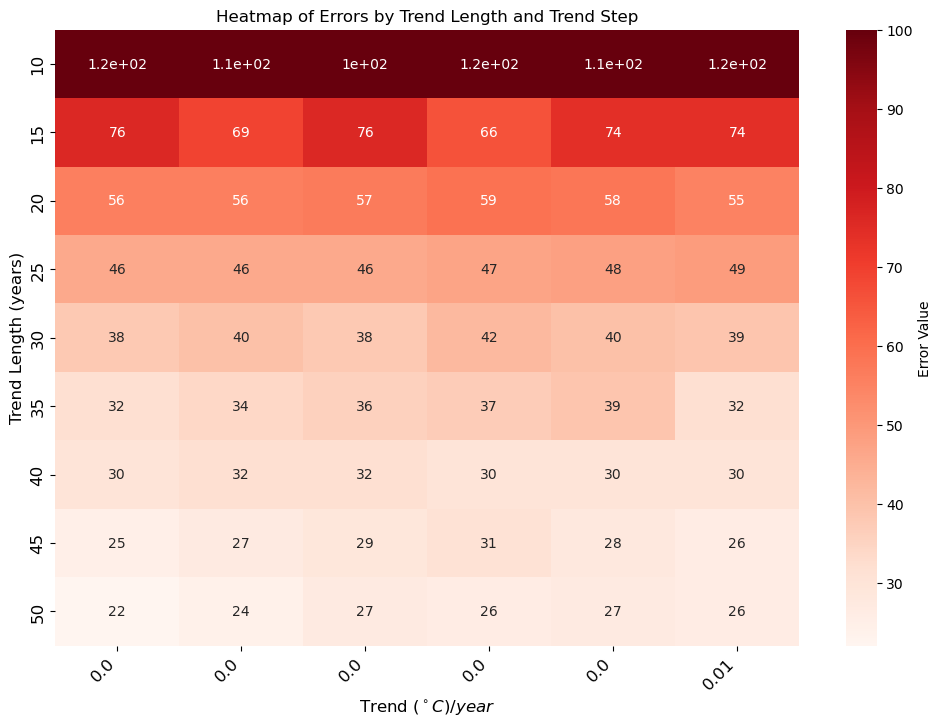

In [146]:
# Plot heatmap of errors
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
sns.heatmap(std_percent_df, cmap='Reds', annot=True, vmax=100, cbar_kws={'label': 'Error Value'})
ax.set_title('Heatmap of Errors by Trend Length and Trend Step')
ax.set_xlabel(r'Trend ($^\circ C) / year$', fontsize=12)
ax.set_ylabel('Trend Length (years)', fontsize=12)
# ax.set_xticks(rotation=45)  # Rotate x-axis labels for better readability
ax.set_xticklabels(std_percent_df.columns.round(2));
# Rotate and resize x-axis tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate labels by 45 degrees and set font size
plt.yticks(fontsize=12) ;

In [147]:
# Compute the total change array
total_change = mean_df.index.values[:, np.newaxis] * mean_df.columns.values

# Create a new DataFrame for total change
total_change_df = pd.DataFrame(total_change, index=mean_df.index, columns=mean_df.columns)
total_change_df

trend_step,0.001,0.002,0.003,0.004,0.005,0.006
trend_length,,,,,,
10,0.010,0.02,0.030,0.04,0.050,0.06
15,0.015,0.03,0.045,0.06,0.075,0.09
20,0.020,0.04,0.060,0.08,0.100,0.12
25,0.025,0.05,0.075,0.10,0.125,0.15
30,0.030,0.06,0.090,0.12,0.150,0.18
35,0.035,0.07,0.105,0.14,0.175,0.21
40,0.040,0.08,0.120,0.16,0.200,0.24
45,0.045,0.09,0.135,0.18,0.225,0.27
50,0.050,0.10,0.150,0.20,0.250,0.30


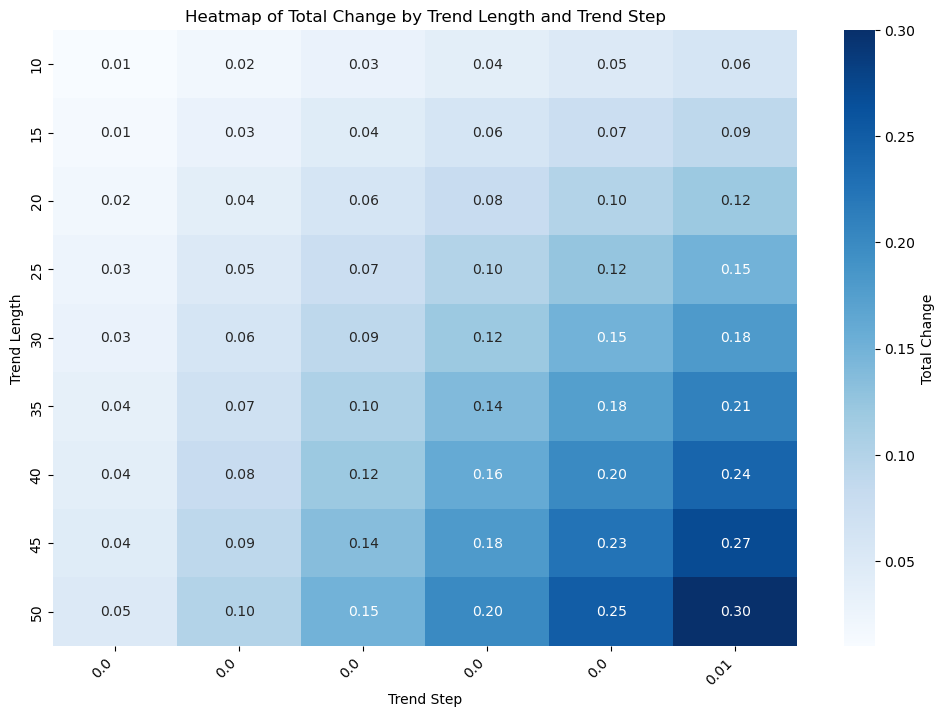

In [148]:

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
sns.heatmap(total_change_df, cmap='Blues', annot=True, fmt=".2f", cbar_kws={'label': 'Total Change'})
ax.set_title('Heatmap of Total Change by Trend Length and Trend Step')
ax.set_xlabel('Trend Step')
ax.set_ylabel('Trend Length')
ax.set_xticklabels(error_df.columns.round(2));

# Rotate and resize x-axis tick labels
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels by 45 degrees and set font size
plt.yticks(fontsize=10);

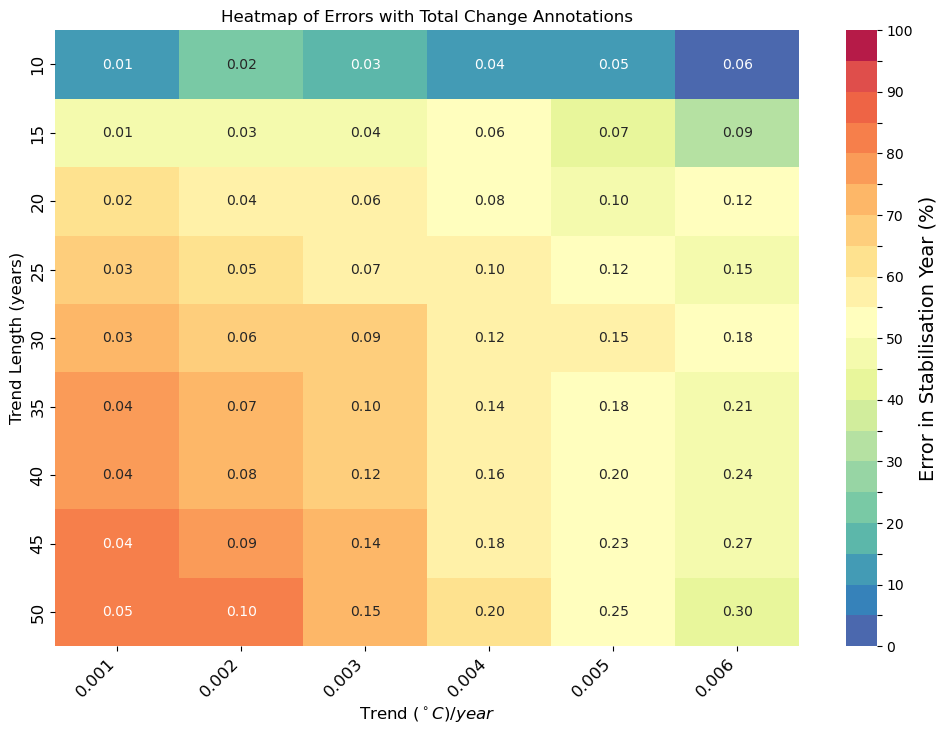

In [149]:

# Define your levels and colors
levels = np.arange(0, 105, 5)
colors = sns.color_palette('Spectral_r', n_colors=len(levels))  # Generate a color palette

# Create a discrete colormap
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=len(levels))

# Plot heatmap of errors with annotations showing total change
fig, ax = plt.subplots(figsize=(12, 8))

# Plot heatmap with colors corresponding to the errors
heatmap = sns.heatmap(error_df, cmap=cmap, norm=norm, annot=total_change_df, fmt=".2f", ax=ax)
                      # cbar_kws={'label': })

# Customize color bar
cbar = heatmap.collections[0].colorbar
cbar.set_ticks(levels)  # Set ticks on the color bar
 # Replace every second label with ''
cbar.set_ticklabels([f'{level}' if idx % 2 == 0 else '' for idx, level in enumerate(levels)]) 
cbar.set_label('Error in Stabilisation Year (%)', fontsize=14)  # Set the title and adjust font size


ax.set_xticklabels(error_df.columns.round(4));

# Set plot titles and labels
ax.set_title('Heatmap of Errors with Total Change Annotations')
ax.set_xlabel(r'Trend ($^\circ C) / year$', fontsize=12)
ax.set_ylabel('Trend Length (years)', fontsize=12)

# Rotate and resize x-axis tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12);

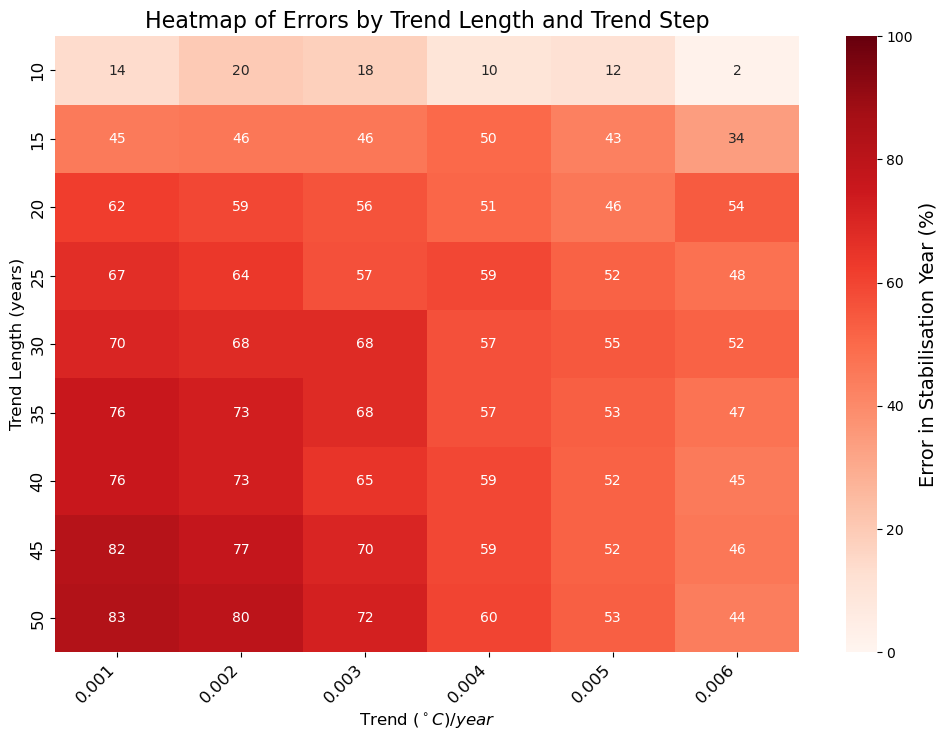

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap of errors
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
heatmap = sns.heatmap(error_df, cmap='Reds', annot=True, vmin=0, vmax=100, cbar_kws={'label': 'Error Value'})

# Access the color bar from the heatmap
cbar = heatmap.collections[0].colorbar
cbar.set_label('Error in Stabilisation Year (%)', fontsize=14)  # Set the title and adjust font size

# Set plot titles and labels
ax.set_title('Heatmap of Errors by Trend Length and Trend Step', fontsize=16)  # Adjust title font size
ax.set_xlabel(r'Trend ($^\circ C) / year$', fontsize=12)
ax.set_ylabel('Trend Length (years)', fontsize=12)
ax.set_xticklabels(error_df.columns.round(4));

# Rotate and resize x-axis tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate labels by 45 degrees and set font size
plt.yticks(fontsize=12)

plt.show()


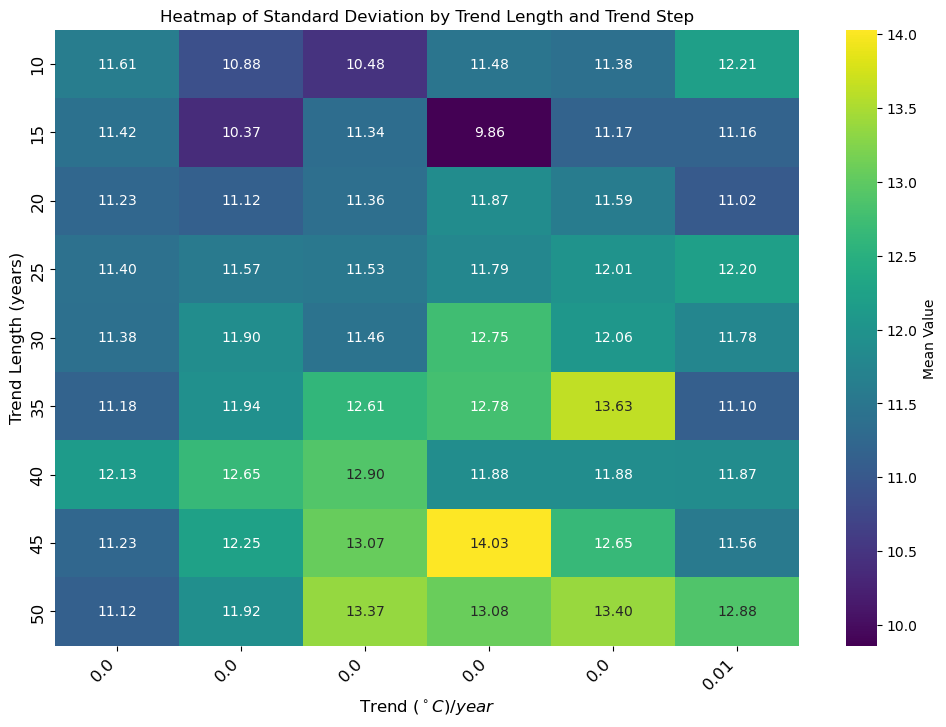

In [151]:
# Plot heatmap
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
sns.heatmap(std_df.astype(float), cmap='viridis', annot=True, fmt=".2f", cbar_kws={'label': 'Mean Value'})
ax.set_title('Heatmap of Standard Deviation by Trend Length and Trend Step')
ax.set_xlabel(r'Trend ($^\circ C) / year$', fontsize=12)
ax.set_ylabel('Trend Length (years)', fontsize=12)
ax.set_xticklabels(error_df.columns.round(2));
# Rotate and resize x-axis tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate labels by 45 degrees and set font size
plt.yticks(fontsize=12) ;

In [ ]:

# Plot heatmap
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
heatmap = sns.heatmap(mean_df.astype(float), cmap='Spectral_r', annot=True, fmt=".0f", cbar_kws={'label': 'Mean Value'})

# Access and adjust color bar title
cbar = heatmap.collections[0].colorbar
cbar.set_label('Mean Year of Stabilisation', fontsize=14)  # Set color bar title and adjust font size

# Set plot titles and labels
ax.set_title('Heatmap of Mean Values by Trend Length and Trend Step', fontsize=16)  # Adjust title font size
ax.set_xlabel(r'Trend ($^\circ C) / year$', fontsize=14)
ax.set_ylabel('Trend Length (years)', fontsize=14)
ax.set_xticklabels(mean_df.columns.round(4));

# Rotate and resize x-axis tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate labels by 45 degrees and set font size
plt.yticks(fontsize=12)

plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
expected = np.arange(10, 51, 1)
# Define colormap
cmap = cm.get_cmap('coolwarm', len(mean_df.columns))

# Plot each line with different colors from the colormap
for i, column in enumerate(mean_df.columns):
    ax.plot(mean_df.index, mean_df[column], color=cmap(i / len(mean_df.columns)), label=column)

# Add expected line
ax.plot(expected, expected, color='k', label='Expected', linewidth=3)

# Customize labels and title
ax.set_xlabel('Forced Signal Trend Length', fontsize=14)
ax.set_ylabel('Estimate Year of Stabilisation', fontsize=14)

ax.legend(title='Trend ($^\circ C) / year$', title_fontsize='13', fontsize='12')

In [ ]:
expected = np.arange(10, 51)
mean_df.plot()
plt.plot(expected, expected, color='k', label='expected', linewidth=3)